In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from joypy import joyplot
import os
plt.rcParams["svg.fonttype"] = "none"  # Ensures the text is not converted to paths
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.inspection import PartialDependenceDisplay
import shap
import matplotlib.colors as mcolors
import itertools
from matplotlib import cm
from itertools import chain, combinations
from scipy.stats import pearsonr
from scipy.stats import ttest_1samp
from matplotlib.colors import LinearSegmentedColormap, Normalize

In [ ]:
main_dir = 'Model_Training/Models/Final_Training_Run_ALL'
# main_dir = 'Model_Training/Models/Control_Training_Run'  # for control models
results = {}

for training_run in os.listdir(main_dir):
    print(f"Processing training run: {training_run}")
    training_run_path = os.path.join(main_dir, training_run)
    test_set = set(pd.read_csv(os.path.join(main_dir, training_run, 'created_datasets', "testing.tsv"), sep='\t')["transcript_id"])
    val_set = set(pd.read_csv(os.path.join(main_dir, training_run, 'created_datasets', "validation.tsv"), sep='\t')["transcript_id"])
    test_and_val_set = test_set.union(val_set)

    for subdir in os.listdir(training_run_path):
        subdir_path = os.path.join(training_run_path, subdir)
        results[training_run] = results.get(training_run, {})
        if subdir not in results[training_run]:
            if os.path.isdir(subdir_path):
                eval_model_dir = os.path.join(subdir_path, 'evaluated_trained_model')
                file_path = os.path.join(eval_model_dir, 'original_file_with_predictions.tsv')
                
                if os.path.exists(file_path):
                    print(f"Processing file: {file_path}")

                    df = pd.read_csv(file_path, sep='\t')
                    df = df[df['transcript_id'].isin(test_and_val_set)]
                    
                    if 'control_common' in df.columns:
                        y_true = df['control_common'].map({True: 0, False: 1}).values
                        
                        y_score = df.iloc[:, -1].values
                        
                        try:
                            y_score = y_score.astype(float)
                        except ValueError:
                            print(f"Error: Prediction scores in {file_path} are not numeric.")
                            continue
                        
                        y_pred = (y_score >= 0.5).astype(int)
                        
                        accuracy = accuracy_score(y_true, y_pred)
                        
                        try:
                            auc = roc_auc_score(y_true, y_score)
                        except ValueError:
                            print(f"Warning: Only one class present in y_true for {file_path}. AUC score cannot be computed.")
                            auc = float('nan')
                        
                        results[training_run][subdir] = {'accuracy': accuracy, 'auc': auc}
                    else:
                        print(f"Error: 'control_common' column not found in {file_path}.")
                else:
                    print(f"File does not exist: {file_path}")


In [9]:
flattened_data = []
for run, features in results.items():
    for feature_combo, metrics in features.items():
        if "copy" in feature_combo:
            continue
        flattened_data.append({
            'run': run,
            'datasets': feature_combo,
            'accuracy': metrics['accuracy'],
            'auc': metrics['auc']
        })

results_df = pd.DataFrame(flattened_data)

results_df.to_csv('Results/machine_learning_results/performances/performance_results_full_all.csv', index=False)
# results_df.to_csv('Results/machine_learning_results/performances/performance_results_full_control.csv', index=False)  # for control models


In [15]:
results_df["run"].value_counts()

training_run_12092024_163624677    127
training_run_19092024_085512249    127
training_run_19092024_085523219    127
training_run_12092024_163606403    127
training_run_19092024_085510036    127
training_run_12092024_090155232    127
training_run_19092024_085518451    127
training_run_12092024_163543175    127
Name: run, dtype: int64

In [5]:
results_df = pd.read_csv('Results/machine_learning_results/performances/performance_results_full_all.csv', sep='\t')
results_df_control = pd.read_csv('Results/machine_learning_results/performances/performance_results_full_control.csv', sep='\t')

def split_name_string_to_binary_columns(results_df):
    split_df = results_df['datasets'].str.get_dummies(sep=':')

    result_df_new = pd.concat([results_df.drop('datasets', axis=1), split_df], axis=1)

    result_df_new['paris_inter'] = result_df_new[['paris_intergroup', 'paris_intragroup']].max(axis=1)

    result_df_new = result_df_new.drop(columns=['paris_intergroup', 'paris_intragroup'])
    
    return result_df_new

result_df_new = split_name_string_to_binary_columns(results_df)

result_df_new = pd.concat([result_df_new, results_df_control], axis=0)

result_df_new["Num. Included Datasets"] = result_df_new[['global_iclip', 'm6a', 'paris_intramol', 'postar3', 'rnafold', 'sequence', 'paris_inter']].sum(axis=1)
result_df_new[result_df_new["Num. Included Datasets"] == 1].sort_values(by="auc", ascending=False)
result_df_new

,run,accuracy,auc,global_iclip,m6a,paris_intramol,postar3,rnafold,sequence,paris_inter,Num. Included Datasets
0,training_run_12092024_163624677,0.834239,0.923423,0,0,0,1,1,1,0,3
1,training_run_12092024_163624677,0.730978,0.820344,0,0,1,0,1,0,1,3
2,training_run_12092024_163624677,0.770380,0.868107,0,1,1,1,1,0,0,4
3,training_run_12092024_163624677,0.836957,0.919694,1,0,0,0,0,1,1,3
4,training_run_12092024_163624677,0.755435,0.833459,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
3,training_run_19092024_181444042,0.739130,0.816305,0,0,0,0,0,0,0,0
4,training_run_19092024_181444042,0.733696,0.815847,0,0,0,0,0,0,0,0
5,training_run_19092024_181444042,0.729620,0.820189,0,0,0,0,0,0,0,0
6,training_run_19092024_181444042,0.733696,0.817235,0,0,0,0,0,0,0,0


In [4]:
result_df_new["run"].value_counts()

training_run_12092024_163624677    127
training_run_19092024_085512249    127
training_run_19092024_085523219    127
training_run_12092024_163606403    127
training_run_19092024_085510036    127
training_run_12092024_090155232    127
training_run_19092024_085518451    127
training_run_12092024_163543175    127
training_run_19092024_181444042      8
Name: run, dtype: int64

In [3]:
true_false_columns = ["global_iclip",	"m6a",	"paris_intramol",	"postar3"	,"rnafold"	,"sequence"	,"paris_inter"]

max_accuracy_df = result_df_new.groupby(true_false_columns).accuracy.max().reset_index()
max_auc_df = result_df_new.groupby(true_false_columns).auc.max().reset_index()

max_accuracy_df.columns = ["Global iCLIP", "m6A", "PARIS Intra", "POSTAR3", "RNAfold", "Sequence", "PARIS Inter", "Accuracy"]
max_auc_df.columns = ["Global iCLIP", "m6A", "PARIS Intra", "POSTAR3", "RNAfold", "Sequence", "PARIS Inter", "AUC Score"]
true_false_columns = ["Global iCLIP", "m6A", "PARIS Intra", "POSTAR3", "RNAfold", "Sequence", "PARIS Inter"]

max_auc_df

,Global iCLIP,m6A,PARIS Intra,POSTAR3,RNAfold,Sequence,PARIS Inter,AUC Score
0,0,0,0,0,0,0,0,0.822345
1,0,0,0,0,0,0,1,0.833828
2,0,0,0,0,0,1,0,0.912125
3,0,0,0,0,0,1,1,0.916512
4,0,0,0,0,1,0,0,0.820691
...,...,...,...,...,...,...,...,...
123,1,1,1,1,0,1,1,0.929493
124,1,1,1,1,1,0,0,0.885651
125,1,1,1,1,1,0,1,0.893215
126,1,1,1,1,1,1,0,0.935534


In [10]:
result_df_new.columns = ["run",	"Accuracy",	"AUC", "Global iCLIP", "m6A", "PARIS Intra", "POSTAR3", "RNAfold", "Sequence", "PARIS Inter"]
max_auc_df_merged = pd.merge(result_df_new, max_auc_df)
max_auc_df_merged["num_datasets"] = max_auc_df_merged[true_false_columns].sum(axis=1)
max_auc_df_merged["included_datasets"] = max_auc_df_merged[true_false_columns].apply(lambda x: ", ".join([col for col in true_false_columns if x[col]]), axis=1)

max_auc_df_merged = max_auc_df_merged[max_auc_df_merged["AUC"] == max_auc_df_merged["AUC Score"]]
max_auc_df_merged.sort_values(by='AUC', ascending=False).head(10)


,run,Accuracy,AUC,Global iCLIP,m6A,PARIS Intra,POSTAR3,RNAfold,Sequence,PARIS Inter,AUC Score,num_datasets,included_datasets
661,training_run_12092024_090155232,0.849185,0.936738,0,1,1,1,1,1,1,0.936738,6,"m6A, PARIS Intra, POSTAR3, RNAfold, Sequence, ..."
918,training_run_12092024_163543175,0.832880,0.936147,0,1,1,1,1,1,0,0.936147,5,"m6A, PARIS Intra, POSTAR3, RNAfold, Sequence"
404,training_run_12092024_163606403,0.838315,0.935534,1,1,1,1,1,1,0,0.935534,6,"Global iCLIP, m6A, PARIS Intra, POSTAR3, RNAfo..."
494,training_run_12092024_163606403,0.832880,0.935179,1,1,1,1,1,1,1,0.935179,7,"Global iCLIP, m6A, PARIS Intra, POSTAR3, RNAfo..."
967,training_run_12092024_163543175,0.824728,0.934825,0,0,1,1,1,1,0,0.934825,4,"PARIS Intra, POSTAR3, RNAfold, Sequence"
723,training_run_12092024_090155232,0.834239,0.933754,1,1,0,1,1,1,1,0.933754,6,"Global iCLIP, m6A, POSTAR3, RNAfold, Sequence,..."
35,training_run_12092024_163624677,0.834239,0.933710,0,0,0,1,0,1,1,0.933710,3,"POSTAR3, Sequence, PARIS Inter"
381,training_run_12092024_163606403,0.831522,0.933584,0,0,0,1,1,1,0,0.933584,3,"POSTAR3, RNAfold, Sequence"
15,training_run_12092024_163624677,0.847826,0.933474,0,1,0,1,1,1,0,0.933474,4,"m6A, POSTAR3, RNAfold, Sequence"
24,training_run_12092024_163624677,0.828804,0.932750,1,0,0,1,1,1,1,0.932750,5,"Global iCLIP, POSTAR3, RNAfold, Sequence, PARI..."


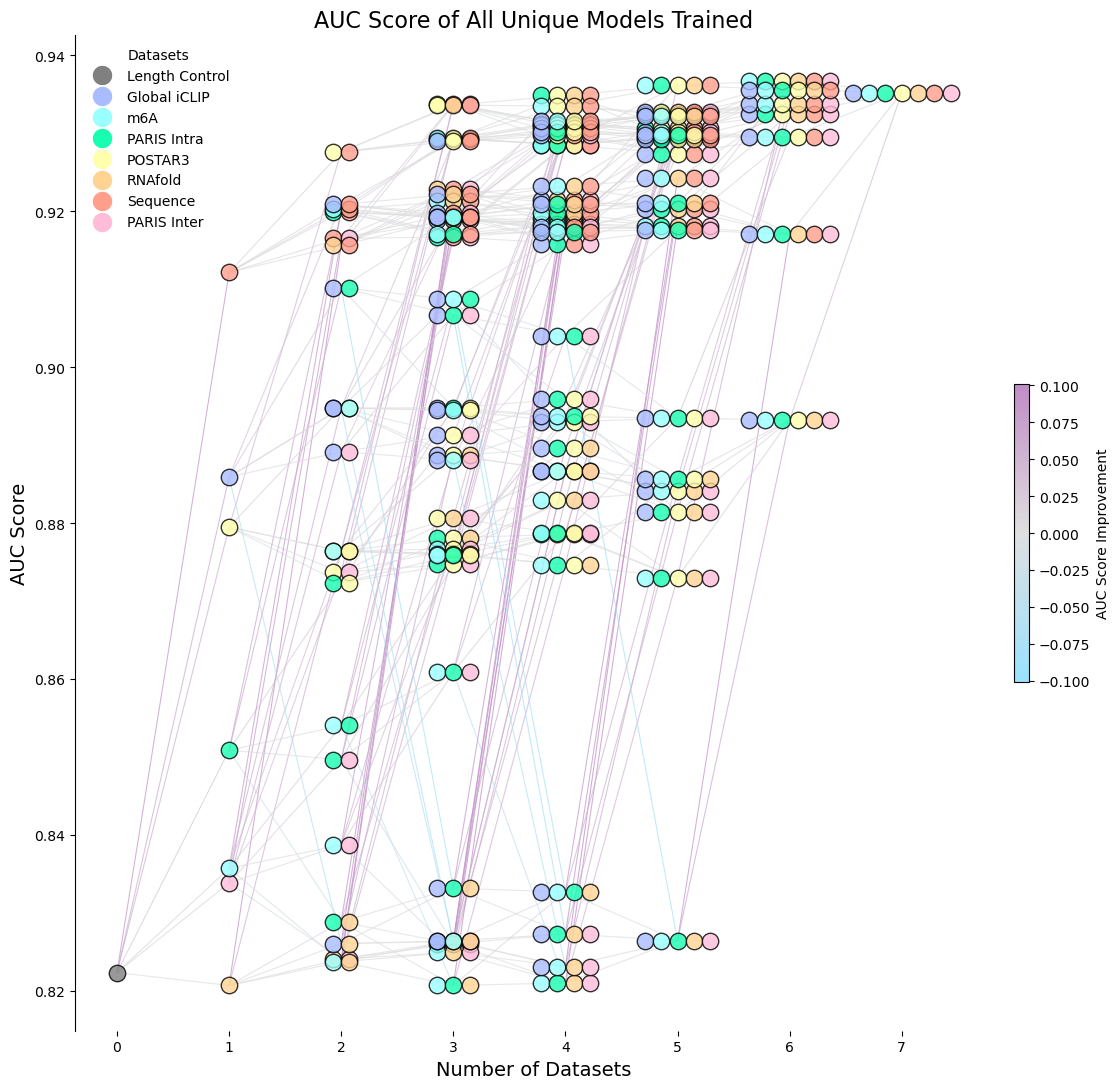

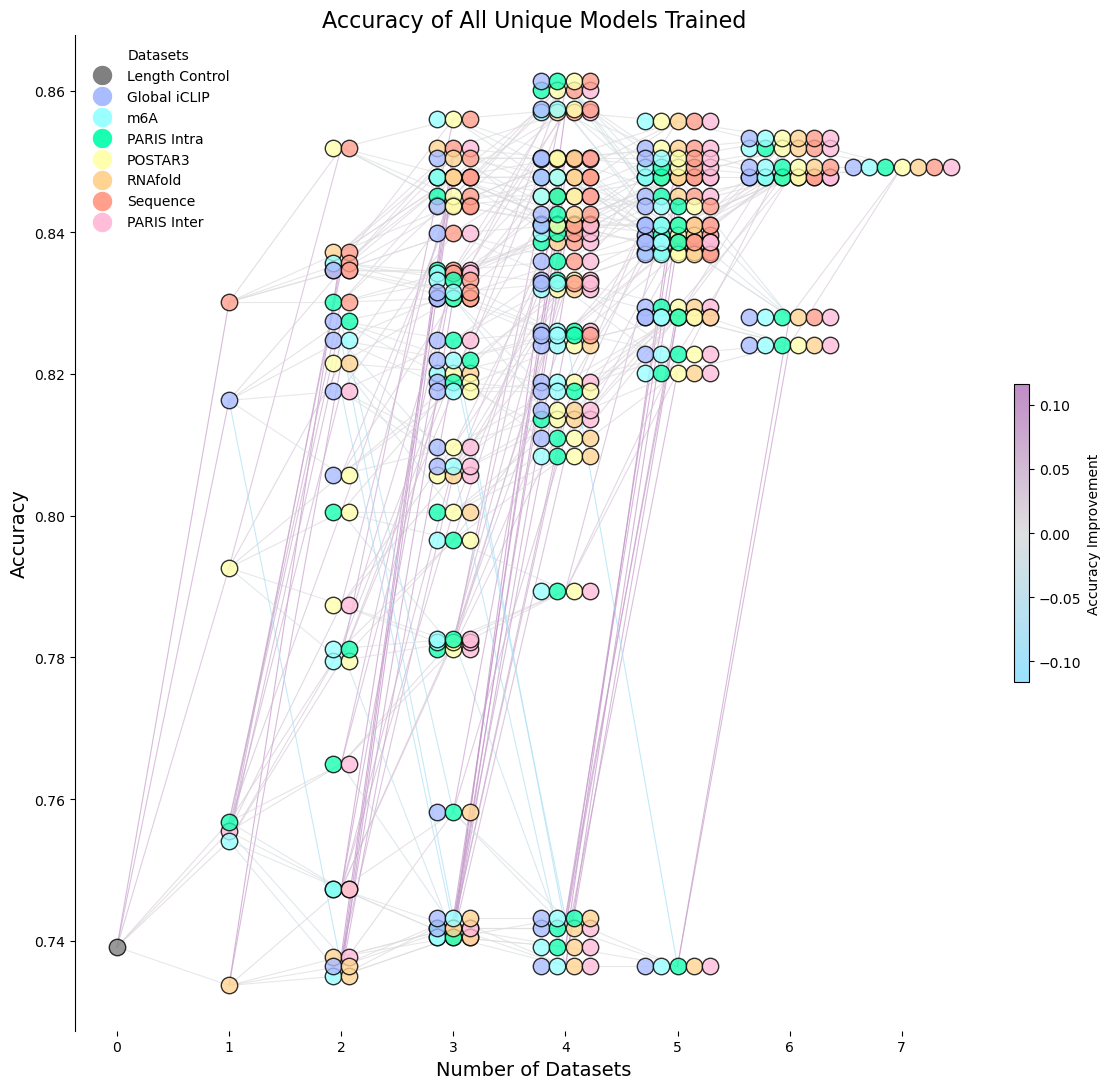

In [34]:
def plot_accuracy(df, column):
    df = df.copy()
    df["num_datasets"] = df[true_false_columns].sum(axis=1)
    df["included_datasets"] = df[true_false_columns].apply(lambda x: ", ".join([col for col in true_false_columns if x[col]]), axis=1)
    df.loc[df["included_datasets"] == "", "included_datasets"] = "Length Control"

    datasets = ['Length Control', 'Global iCLIP', 'm6A', 'PARIS Intra', 'POSTAR3', 'RNAfold', 'Sequence', 'PARIS Inter']
    colors = ['#808080', "#a9bcff", "#9affff", "#18ffb1", "#ffffad", "#ffd493", "#ff9f8c", "#ffbdda"]

    dataset_colors = dict(zip(datasets, colors))

    df['dataset_list'] = df['included_datasets'].apply(lambda x: x.split(', '))

    fig, ax = plt.subplots(figsize=(12, 11))

    offset_per_dot = 0.145

    for idx, row in df.iterrows():
        x = row['num_datasets']
        y = row[column]
        datasets_included = row['dataset_list']
        n_datasets = len(datasets_included)

        total_offset = (n_datasets - 1) * offset_per_dot
        start_offset = -total_offset / 2
        offsets = [start_offset + i * offset_per_dot for i in range(n_datasets)]
        for i, dataset in enumerate(datasets_included):
            xi = x + offsets[i]
            ax.scatter(xi, y, color=dataset_colors[dataset], edgecolors='k', zorder=3, alpha=0.8, s=140)

    line_segments = []

    df['dataset_set'] = df['dataset_list'].apply(set)
    for idx, row in df.iterrows():
        current_set = row['dataset_set']
        current_x = row['num_datasets']
        current_y = row[column]

        prev_rows = df[df['num_datasets'] == current_x - 1]
        for _, prev_row in prev_rows.iterrows():
            prev_set = prev_row['dataset_set']
            if prev_set.issubset(current_set) or current_x == 1:
                prev_x = prev_row['num_datasets']
                prev_y = prev_row[column]
                accuracy_diff = current_y - prev_y

                line_segments.append({
                    'x': [prev_x, current_x],
                    'y': [prev_y, current_y],
                    'accuracy_diff': accuracy_diff
                })


    accuracy_diffs = [seg['accuracy_diff'] for seg in line_segments]
    min_diff = min(accuracy_diffs)
    max_diff = max(accuracy_diffs)
    abs_max = max(abs(min_diff), abs(max_diff))

    norm = Normalize(vmin=-abs_max, vmax=abs_max)

    colors = ['#99E2FF', '#DFDFDF', '#C08CC6']


    colormap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)


    for seg in line_segments:
        x = seg['x']
        y = seg['y']
        norm_diff = norm(seg['accuracy_diff'])
        color = colormap(norm_diff)
        ax.plot(x, y, color=color, linestyle='-', linewidth=0.8, zorder=1, alpha=0.7)


    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.02, shrink=0.3)
    cbar.set_label(f'{column} Improvement')


    handles = [plt.Line2D([0], [0], marker='o', color='w', label=dataset,
                          markerfacecolor=dataset_colors[dataset], markersize=15) for dataset in datasets]
    ax.legend(handles=handles, title='Datasets', frameon=False)
    

    ax.set_xlabel('Number of Datasets', fontsize=14)
    ax.set_ylabel(column, fontsize=14)
    ax.set_title(f'{column} of All Unique Models Trained', fontsize=16)
    ax.set_facecolor('white')
    plt.tight_layout()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_color('black')

    plt.show()


plot_accuracy(max_auc_df, 'AUC Score')
plot_accuracy(max_accuracy_df, 'Accuracy')


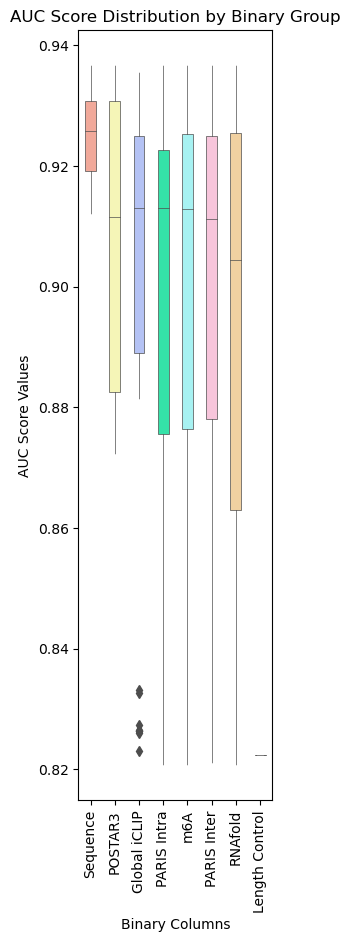

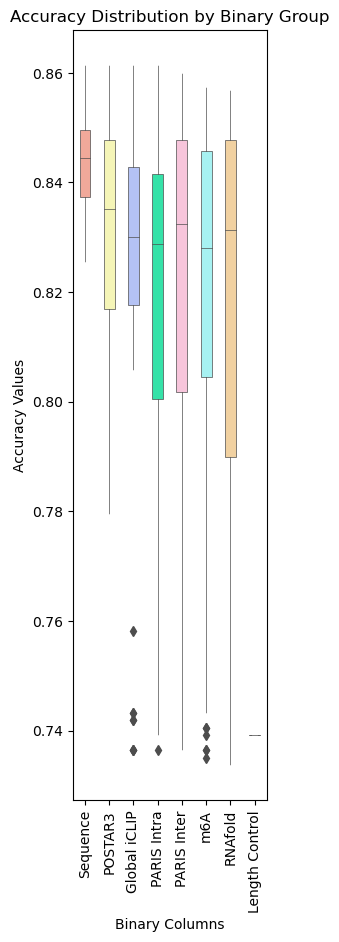

In [91]:
def plot_column_by_binary_groups_boxplot_custom_palette(df, column_name):

    df["Length Control"] = 0
    df.loc[(df["Global iCLIP"] == 0) & (df["m6A"] == 0) & (df["PARIS Intra"] == 0) & (df["POSTAR3"] == 0) & (df["RNAfold"] == 0) & (df["Sequence"] == 0) & (df["PARIS Inter"] == 0), "Length Control"] = 1

    binary_columns = ['Length Control', 'Global iCLIP', 'm6A', 'PARIS Intra', 'POSTAR3', 'RNAfold', 'Sequence', 'PARIS Inter']
    colors = ['#808080', "#a9bcff", "#9affff", "#18ffb1", "#ffffad", "#ffd493", "#ff9f8c", "#ffbdda"]


    custom_palette = dict(zip(binary_columns, colors))


    long_form_data = pd.DataFrame()

    for col in binary_columns:

        filtered_df = df[df[col] == 1][[column_name]].copy()
        filtered_df['Group'] = col
        long_form_data = pd.concat([long_form_data, filtered_df], axis=0)


    long_form_data['Group'] = pd.Categorical(
        long_form_data['Group'], 
        categories=long_form_data.groupby('Group')[column_name].mean().sort_values(ascending=False).index,
        ordered=True
    )


    plt.figure(figsize=(2.5, 10))
    sns.boxplot(x='Group', y=column_name, data=long_form_data, palette=custom_palette, linewidth=0.5, width=0.45, 
                capprops=dict(color="white"))


    plt.xlabel('Binary Columns')
    plt.ylabel(f'{column_name} Values')
    plt.title(f'{column_name} Distribution by Binary Group')
    plt.xticks(rotation=90)

    plt.show()

    df.drop(columns=['Length Control'], inplace=True)

plot_column_by_binary_groups_boxplot_custom_palette(max_auc_df, 'AUC Score')
plot_column_by_binary_groups_boxplot_custom_palette(max_accuracy_df, 'Accuracy')

In [6]:
def prepare_data_for_sunburst(df, column):
    max_auc_df_for_sunburst = df.copy()

    new_data = {
        'Subdirectory_tuple': [],
        column: []
    }

    for _, row in max_auc_df_for_sunburst.iterrows():
        subdirectory_tuple = tuple(col for col in max_auc_df_for_sunburst.columns[:-1] if row[col] == 1)  
        new_data['Subdirectory_tuple'].append(subdirectory_tuple)
        new_data[column].append(row[column])

    max_auc_df_for_sunburst = pd.DataFrame(new_data)
    return max_auc_df_for_sunburst

max_auc_df_for_sunburst = prepare_data_for_sunburst(max_auc_df, 'AUC Score')
max_accuracy_for_sunburst = prepare_data_for_sunburst(max_accuracy_df, 'Accuracy')

In [49]:
def calculate_improvements(result_df, column):

    def powerset(iterable):
        s = list(iterable)
        return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

    columns = ["Global iCLIP", "m6A", "PARIS Intra", "POSTAR3", "Sequence", "PARIS Inter", "RNAfold"]

    results = []
    for col in columns:

        other_columns = [c for c in columns if c != col]
        for subset in powerset(other_columns):

            subset_condition = (result_df[list(subset)].sum(axis=1) == len(subset)) & (result_df[columns].sum(axis=1) == len(subset))
            subset_accuracy = result_df.loc[subset_condition, column].mean()
            subset_with_col_condition = (result_df[list(subset)].sum(axis=1) == len(subset)) & (result_df[other_columns].sum(axis=1) == len(subset)) & (result_df[col] == 1)
            subset_with_col = result_df.loc[subset_with_col_condition, column].mean()
            improvement = subset_with_col - subset_accuracy

            results.append({
                'target_column': col,
                'subset_columns': subset,
                f'{column} Improvement': improvement,

            })

    results_df = pd.DataFrame(results)
    return results_df

if "RNAfold" in max_accuracy_df.columns:
    max_accuracy_df_no_rnafold = max_accuracy_df[max_accuracy_df["RNAfold"] == 0]
    max_accuracy_df_no_rnafold = max_accuracy_df_no_rnafold.drop(columns=["RNAfold"])
    
if "RNAfold" in max_auc_df.columns:
    max_auc_df_no_rnafold = max_auc_df[max_auc_df["RNAfold"] == 0]
    max_auc_df_no_rnafold = max_auc_df_no_rnafold.drop(columns=["RNAfold"])

accuracy_improvements_df = calculate_improvements(max_accuracy_df, "Accuracy")
auc_improvements_df = calculate_improvements(max_auc_df, "AUC Score")

/tmp/ipykernel_3372971/4244155204.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = df_differences.groupby('target_column').mean()


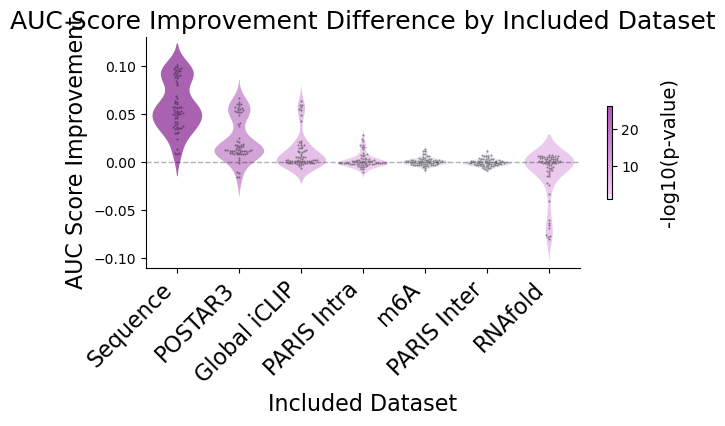

/tmp/ipykernel_3372971/4244155204.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = df_differences.groupby('target_column').mean()


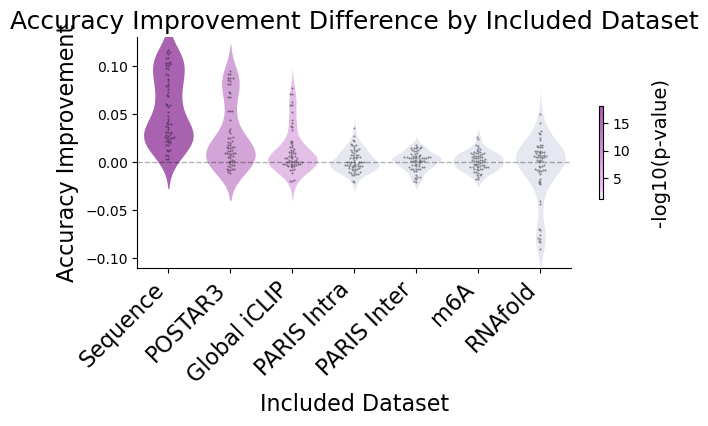

In [95]:
def plot_differences(df_differences, column, p_value_threshold=0.01):
    df_differences = df_differences.dropna(subset=[column])

    grouped = df_differences.groupby('target_column').mean()
    sorted_mean_df = grouped.sort_values(by=column, ascending=False)
    df_differences = df_differences.set_index('target_column').loc[sorted_mean_df.index].reset_index()

    unique_datasets = df_differences['target_column'].unique()
    p_values = {dataset: ttest_1samp(df_differences[df_differences['target_column'] == dataset][column], 0).pvalue for dataset in unique_datasets}
    
    df_differences['p_value'] = df_differences['target_column'].map(p_values)
    df_differences['-log10(p_value)'] = -np.log10(df_differences['p_value'])

    fig, ax = plt.subplots(figsize=(7, 3))

    grey_cmap = mcolors.LinearSegmentedColormap.from_list('grey_cmap', ['#E4E7F3', '#E4E7F3'], N=256)

    colors = ['#F4CBF8', '#B355BD']
    cool_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    colors = np.vstack((
        grey_cmap(np.linspace(0, 1, int(256 * (-np.log10(p_value_threshold) / df_differences['-log10(p_value)'].max())))),
        cool_cmap(np.linspace(0, 1, int(256 * (1 - (-np.log10(p_value_threshold) / df_differences['-log10(p_value)'].max())))))
    ))
    cmap = mcolors.LinearSegmentedColormap.from_list('combined_cmap', colors)

    palette = []
    max_value = df_differences['-log10(p_value)'].max()
    for dataset in unique_datasets:
        dataset_mean = df_differences[df_differences['target_column'] == dataset]['-log10(p_value)'].mean()
        palette.append(cmap(dataset_mean / max_value))

    sns.violinplot(x='target_column', y=column, data=df_differences, inner=None,
                   palette=palette, linewidth=0, ax=ax, scale='width')
    sns.swarmplot(x='target_column', y=column, data=df_differences, color='black', size=1.5, alpha=0.4, ax=ax)

    plt.title(f'{column} Difference by Included Dataset', fontsize=18)
    plt.xlabel('Included Dataset', fontsize=16)

    plt.ylabel(column, fontsize=16)

    plt.xticks(
        ticks=range(len(unique_datasets)),
        labels=[item for item in unique_datasets],
        rotation=45,
        ha='right',
        fontsize=16
    )

    plt.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
    sns.despine()

    norm = mcolors.Normalize(vmin=-np.log10(p_value_threshold), vmax=max_value)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm, )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.4)
    cbar.set_label('-log10(p-value)', labelpad=15, fontsize=14)

    ax.grid(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')

    plt.show()

plot_differences(auc_improvements_df, 'AUC Score Improvement', p_value_threshold=0.05)
plot_differences(accuracy_improvements_df, 'Accuracy Improvement', p_value_threshold=0.05)

In [ ]:
def powerset(iterable):
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

def analyze_redundancy(df, binary_cols, accuracy_col):
    performances_all = []
    
    for dataset_a, dataset_b in combinations(binary_cols, 2):

        remaining_datasets = [col for col in binary_cols if col not in [dataset_a, dataset_b]]
        
        remaining_powerset = powerset(remaining_datasets)

        for subset in remaining_powerset:

            subset_cols = list(subset)

            other_cols = [col for col in remaining_datasets if col not in subset_cols]

            df_cont = df[(df[dataset_a] == 0) & (df[dataset_b] == 0)]
            accuracy_cont = df_cont[(df_cont[subset_cols].sum(axis=1) == len(subset_cols)) & (df_cont[other_cols].sum(axis=1) == 0)][accuracy_col].mean()

            df_a = df[(df[dataset_a] == 1) & (df[dataset_b] == 0)]
            accuracy_a = df_a[(df_a[subset_cols].sum(axis=1) == len(subset_cols)) & (df_a[other_cols].sum(axis=1) == 0)][accuracy_col].mean()

            df_b = df[(df[dataset_a] == 0) & (df[dataset_b] == 1)]
            accuracy_b = df_b[(df_b[subset_cols].sum(axis=1) == len(subset_cols)) & (df_b[other_cols].sum(axis=1) == 0)][accuracy_col].mean()

            df_ab = df[(df[dataset_a] == 1) & (df[dataset_b] == 1)]
            accuracy_ab = df_ab[(df_ab[subset_cols].sum(axis=1) == len(subset_cols)) & (df_ab[other_cols].sum(axis=1) == 0)][accuracy_col].mean()

            if pd.isnull(accuracy_a) or pd.isnull(accuracy_b) or pd.isnull(accuracy_ab):
                print(f"Skipping subset {subset} due to missing values")
                continue
            
            performances = {
                'subset': subset,
                'dataset_a': dataset_a,
                'dataset_b': dataset_b,
                'accuracy_cont': accuracy_cont,
                'accuracy_a': accuracy_a,
                'accuracy_b': accuracy_b,
                'accuracy_ab': accuracy_ab,
            }
            
            performances_all.append(performances)
    
    return pd.DataFrame(performances_all)

binary_columns = ["Global iCLIP", "POSTAR3",  "Sequence", "PARIS Intra"]

performances_accuracy = analyze_redundancy(max_accuracy_df_no_rnafold, binary_columns, 'Accuracy')
performances_auc = analyze_redundancy(max_auc_df_no_rnafold, binary_columns, 'AUC Score')

performances_accuracy["num_datasets"] = performances_accuracy["subset"].apply(lambda x: len(x))
performances_auc["num_datasets"] = performances_auc["subset"].apply(lambda x: len(x))


In [ ]:
def duplicate_and_switch_datasets(df):

    df_switched = df.copy()
    df_switched['dataset_a'], df_switched['dataset_b'] = df['dataset_b'], df['dataset_a']
    df_switched['accuracy_a'], df_switched['accuracy_b'] = df['accuracy_b'], df['accuracy_a']

    df_combined = pd.concat([df, df_switched], ignore_index=True)
    
    return df_combined

performances_accuracy_duplicated = duplicate_and_switch_datasets(performances_accuracy)
performances_auc_duplicated = duplicate_and_switch_datasets(performances_auc)

performances_accuracy_duplicated_no_nan = performances_accuracy_duplicated.dropna()
performances_auc_duplicated_no_nan = performances_auc_duplicated.dropna()

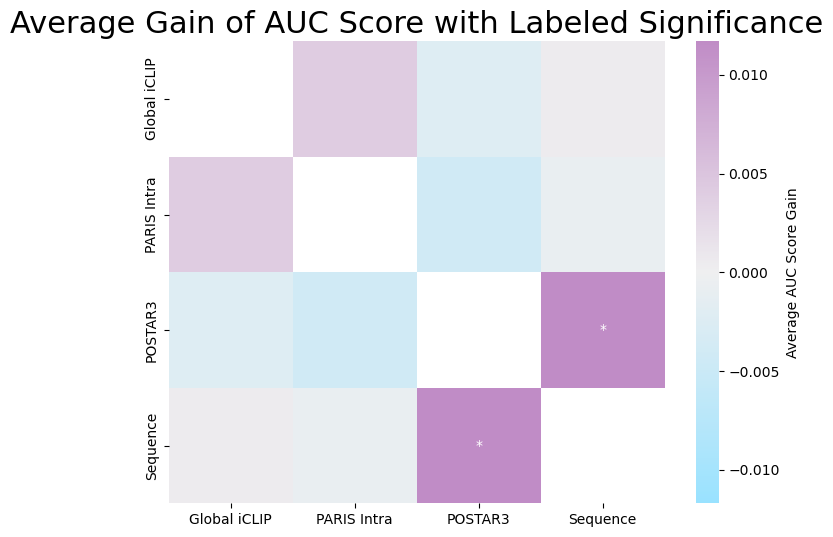

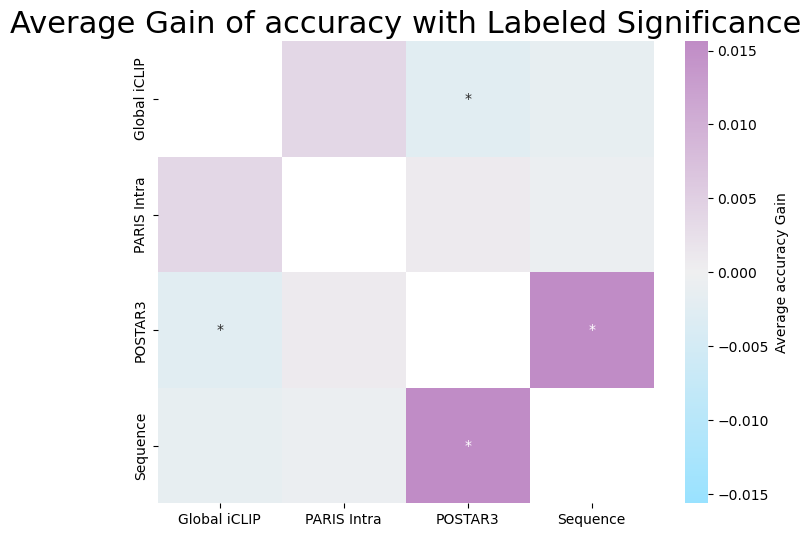

In [86]:
def calculate_gain(df):
    df['gain'] = df['accuracy_ab'] - np.maximum(df['accuracy_a'], df['accuracy_b'])
    return df

def gain_heatmap(df, name, p_value_threshold=0.05):
    df = df.copy()
    df = calculate_gain(df)      
    

    gain_summary = df.groupby(['dataset_a', 'dataset_b'])['gain'].agg(
        avg_gain='mean',
        p_value=lambda x: ttest_1samp(x, 0)[1]
    ).reset_index()

    gain_pivot = gain_summary.pivot(index='dataset_a', columns='dataset_b', values='avg_gain')
    
    significance_pivot = gain_summary.pivot(index='dataset_a', columns='dataset_b', values='p_value')

    annotations = gain_pivot.copy().astype(str)
    
    for i in range(annotations.shape[0]):
        for j in range(annotations.shape[1]):
            p_value = significance_pivot.iloc[i, j]
            if p_value < p_value_threshold:
                annotations.iloc[i, j] = f'*'
            else:
                annotations.iloc[i, j] = f''
    
    vmin = gain_pivot.min().min()
    vmax = gain_pivot.max().max()
    abs_max = max(abs(vmin), abs(vmax))
    
    colors = ['#99E2FF', '#EFEFF0', '#C08CC6']

    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    plt.figure(figsize=(8, 6))
    sns.heatmap(gain_pivot, annot=annotations, fmt='', cmap=cmap, cbar=True, vmin=-abs_max, vmax=abs_max, cbar_kws={'label': f'Average {name} Gain'})

    plt.title(f'Average Gain of {name} with Labeled Significance', fontsize=22)
    plt.gca().set_facecolor('white')
    plt.xlabel('')
    plt.ylabel('')

    plt.show()

gain_heatmap(performances_auc_duplicated, "AUC Score", p_value_threshold=0.05)
gain_heatmap(performances_accuracy_duplicated, "accuracy", p_value_threshold=0.05)
